In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from wordcloud import WordCloud

In [3]:
df = pd.read_csv('/home/chef/src/DAT6003/data/processed/nlp_sentiment_analysis.csv')

In [4]:
# reorder columns to put sentiment columns before text column
df1 = df[['sentiment_label', 'sentiment_score', 'parent_issue_id'] + [col for col in df.columns if col not in ['sentiment_label', 'sentiment_score', 'parent_issue_id']]]
df1.head()

,sentiment_label,sentiment_score,parent_issue_id,Unnamed: 0,created_at,author,author_location,type,text
0,positive,0.617641,NaN,0,2018-11-05T21:35:51Z,ZhaoyueCheng,NaN,issue,Thanks a lot for the port! I have some minor q...
1,negative,0.798381,0.0,0_0,2018-11-05T22:01:47Z,ZhaoyueCheng,NaN,comment,It also seems to me that the SQuAD VERSION can...
2,negative,0.796224,0.0,0_1,2018-11-05T23:20:46Z,abeljim,NaN,comment,It also seems to me that the SQuAD VERSION can...
3,neutral,0.802384,0.0,0_3,2018-11-06T02:05:22Z,abeljim,NaN,comment,"Just ran on 1 GPU batch size of 10, the result..."
4,neutral,0.538394,0.0,0_4,2018-11-06T03:48:21Z,ZhaoyueCheng,NaN,comment,"Sure, Thanks, I'm checking for the reason too,..."


In [5]:
# count how many of each sentiment label
df1['sentiment_label'].value_counts()

sentiment_label
neutral     26444
positive     6856
negative     6753
Name: count, dtype: int64

In [6]:
# view the spread of sentiment score confidence
df1['sentiment_score'].describe()

count    40053.000000
mean         0.734860
std          0.135882
min          0.352357
25%          0.620786
50%          0.747841
75%          0.849596
max          0.990493
Name: sentiment_score, dtype: float64

In [7]:
# Visualising some results
counts_df = df1['sentiment_score'].value_counts()
counts_df.head()

sentiment_score
0.530812    102
0.837178     92
0.837178     85
0.863279     50
0.701751     24
Name: count, dtype: int64

In [8]:
len(counts_df)

39050

Text(0.5, 1.0, 'Number of posts by classification label')

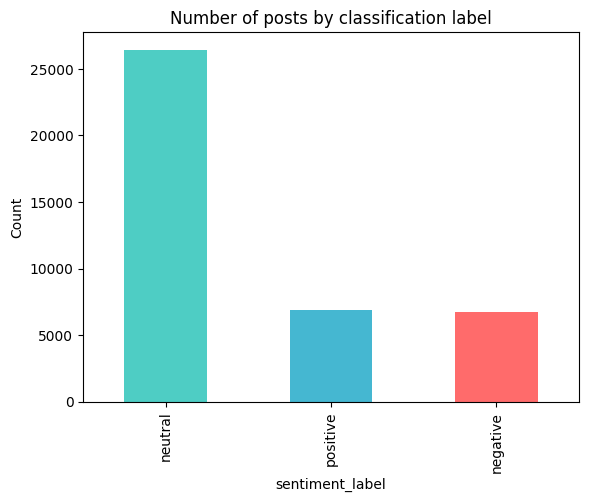

In [9]:
df1['sentiment_label'].value_counts().plot(kind='bar',color=['#4ECDC4', '#45B7D1',  '#FF6B6B'])
plt.ylabel('Count')
plt.title('Number of posts by classification label')

Text(0.5, 1.0, 'Sentiment distribution')

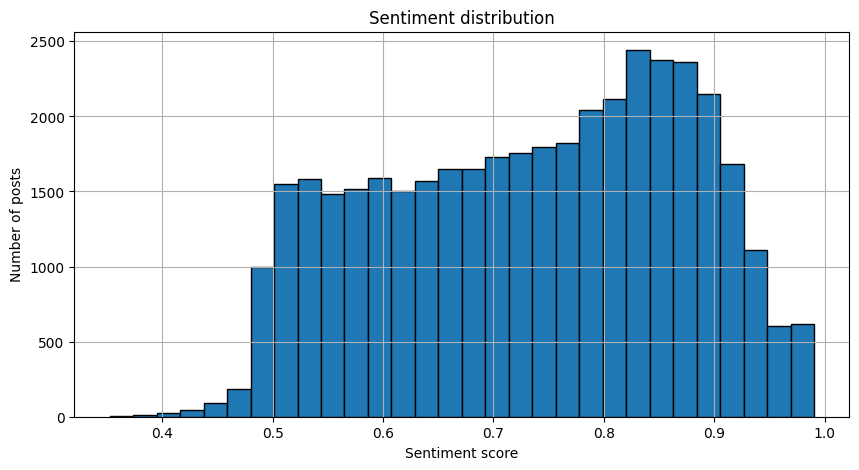

In [10]:
plt.figure(figsize=(10, 5))
df1['sentiment_score'].hist(bins=30, edgecolor='black')
plt.ylabel("Number of posts")
plt.xlabel("Sentiment score")
plt.title("Sentiment distribution")

Text(0.5, 1.0, 'Average sentiment confidence by classification')

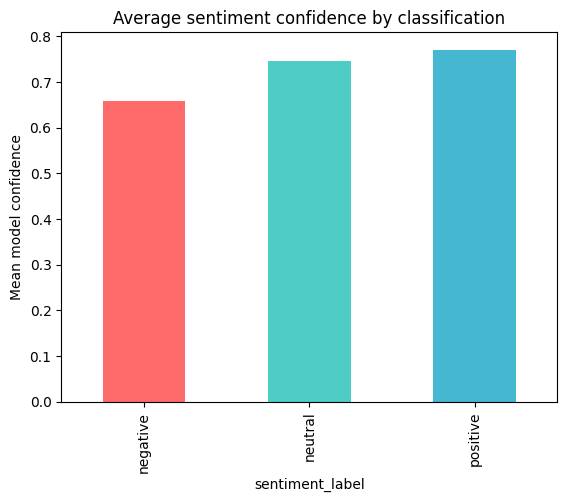

In [11]:
df.groupby("sentiment_label")["sentiment_score"].mean().plot(kind="bar", color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
plt.ylabel("Mean model confidence")
plt.title("Average sentiment confidence by classification")

In [12]:
# Convert created_at column to datetime
df1['created_at'] = pd.to_datetime(df1['created_at'])
df1['created_at'].head()

0   2018-11-05 21:35:51+00:00
1   2018-11-05 22:01:47+00:00
2   2018-11-05 23:20:46+00:00
3   2018-11-06 02:05:22+00:00
4   2018-11-06 03:48:21+00:00
Name: created_at, dtype: datetime64[ns, UTC]

/tmp/ipykernel_86623/1118159518.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  sentiment_over_time_weekly = df1_sorted.groupby([pd.Grouper(freq='M'), 'sentiment_label']).size().unstack(fill_value=0)


<Figure size 1400x600 with 0 Axes>

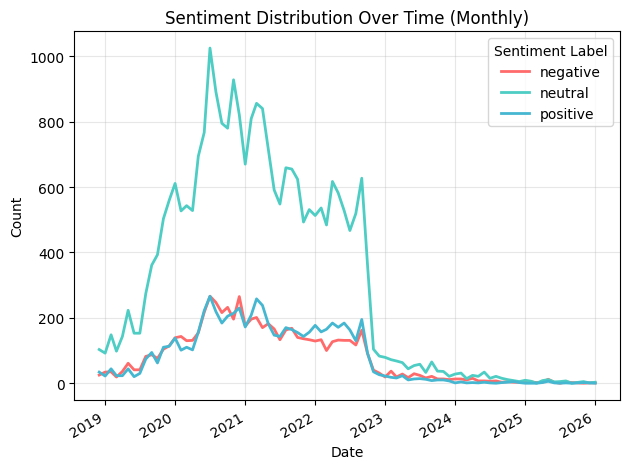

In [13]:
# Sentiment distribution over time (weekly aggregation for cleaner view)
df1_sorted = df1.sort_values('created_at')
df1_sorted.set_index('created_at', inplace=True)
sentiment_over_time_weekly = df1_sorted.groupby([pd.Grouper(freq='M'), 'sentiment_label']).size().unstack(fill_value=0)

plt.figure(figsize=(14, 6))
sentiment_over_time_weekly.plot(kind='line', linewidth=2, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Sentiment Distribution Over Time (Monthly)')
plt.legend(title='Sentiment Label')
plt.grid(True, alpha=0.3)
plt.tight_layout()

<Figure size 1400x600 with 0 Axes>

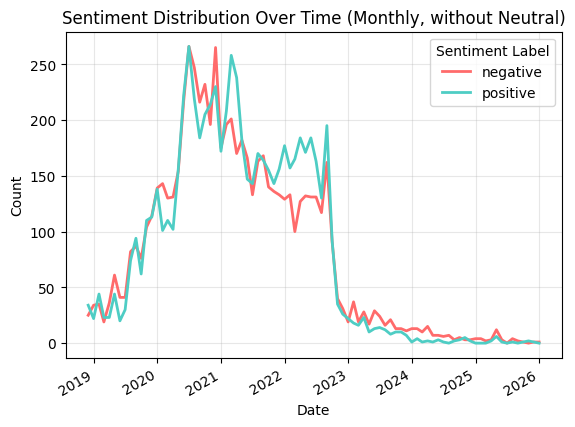

In [35]:
# Plotting without neutral for clarity
plt.figure(figsize=(14, 6))
sentiment_over_time_weekly[['negative', 'positive']].plot(kind='line', linewidth=2, color=['#FF6B6B', '#4ECDC4'])
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Sentiment Distribution Over Time (Monthly, without Neutral)')
plt.legend(title='Sentiment Label')
plt.grid(True, alpha=0.3)

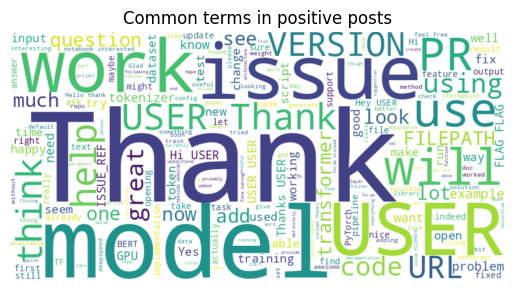

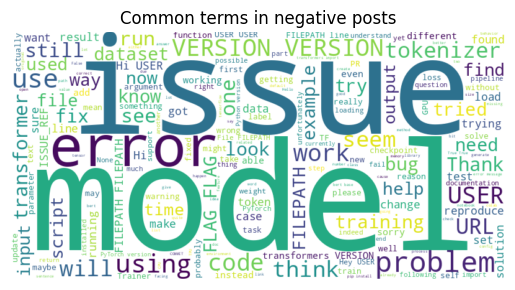

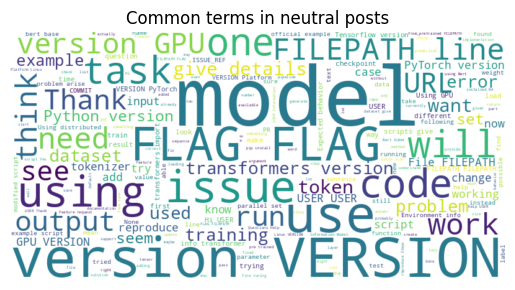

In [14]:
# Plot a wordcloud
def plot_wordcloud(texts, title):
    wc = WordCloud(width=800, height=400, background_color="white").generate(" ".join(texts))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

for label in ["positive", "negative", "neutral"]:
    texts = df[df["sentiment_label"] == label]["text"].dropna().tolist()
    plot_wordcloud(texts, f"Common terms in {label} posts")

<Figure size 2000x1000 with 0 Axes>

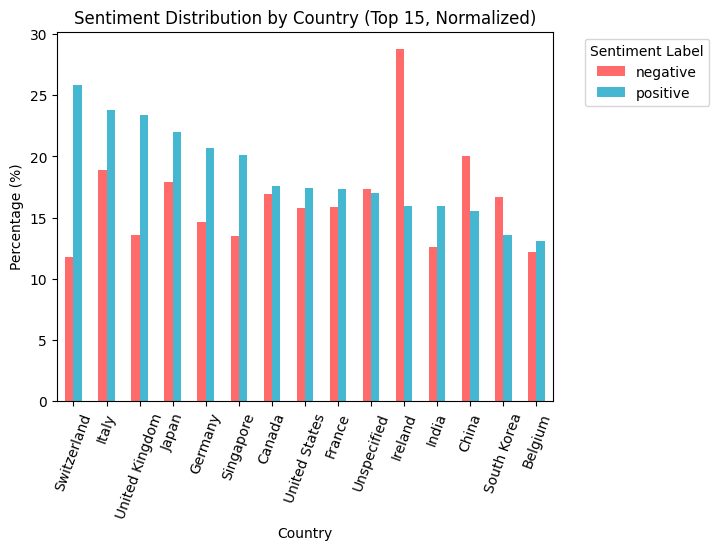

In [ ]:
# Get top 10 countries (treating null as 'unspecified')
df1_with_unspecified = df1.copy()
df1_with_unspecified['author_location'] = df1_with_unspecified['author_location'].fillna('unspecified')
top_countries = df1_with_unspecified['author_location'].value_counts().head(15).index

import geonamescache
gc = geonamescache.GeonamesCache()
country_map = {country['iso']: country['name'] for country in gc.get_countries().values()}
country_map['unspecified'] = 'Unspecified'

# Count sentiment labels by country and normalize to percentages
country_sentiment_counts = df1_with_unspecified[df1_with_unspecified['author_location'].isin(top_countries)].groupby(['author_location', 'sentiment_label']).size().unstack(fill_value=0)
country_sentiment = country_sentiment_counts.div(country_sentiment_counts.sum(axis=1), axis=0) * 100
country_sentiment = country_sentiment.sort_values(by='positive', ascending=False)

country_sentiment.index = country_sentiment.index.map(lambda x: country_map.get(x, x))
country_sentiment = country_sentiment[['negative', 'positive']]  # only keep negative and positive for clarity

plt.figure(figsize=(20, 10))
country_sentiment.plot(kind='bar', color=['#FF6B6B', '#45B7D1'])    
plt.ylabel('Percentage (%)')
plt.xlabel('Country')
plt.title('Sentiment Distribution by Country (Top 15, Normalized)')
plt.legend(title='Sentiment Label', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=70)

In [29]:
country_sentiment_counts['total'] = country_sentiment_counts['negative'] + country_sentiment_counts['positive'] + country_sentiment_counts['neutral']
country_sentiment_counts = country_sentiment_counts.sort_values('total', ascending=False)
country_sentiment_counts

sentiment_label,negative,neutral,positive,total
author_location,,,,
unspecified,4714,17805,4628,27147
US,497,2104,548,3149
CA,296,1147,308,1751
IN,199,1126,251,1576
BE,153,937,164,1254
DE,130,573,183,886
FR,109,459,119,687
CN,95,306,74,475
IE,92,177,51,320


This data does not take into account duplicates - highly active users from identified regions are counted numerous times, so this data is also showing a general, total frequency from those countries but not a unique commenter frequency from those countries. This data will be skewed by highly active users from select locations.

In [39]:
df2 = pd.read_csv('/home/chef/src/DAT6003/data/processed/nlp_sentiment_analysis_with_emotion.csv')

In [40]:
df2.head()

,Unnamed: 0,created_at,author,author_location,type,text,parent_issue_id,sentiment_label,sentiment_score,emotion_label,emotion_score
0,0,2018-11-05T21:35:51Z,ZhaoyueCheng,NaN,issue,Thanks a lot for the port! I have some minor q...,NaN,positive,0.617641,neutral,0.483437
1,0_0,2018-11-05T22:01:47Z,ZhaoyueCheng,NaN,comment,It also seems to me that the SQuAD VERSION can...,0.0,negative,0.798381,neutral,0.521882
2,0_1,2018-11-05T23:20:46Z,abeljim,NaN,comment,It also seems to me that the SQuAD VERSION can...,0.0,negative,0.796224,neutral,0.623931
3,0_3,2018-11-06T02:05:22Z,abeljim,NaN,comment,"Just ran on 1 GPU batch size of 10, the result...",0.0,neutral,0.802384,neutral,0.912427
4,0_4,2018-11-06T03:48:21Z,ZhaoyueCheng,NaN,comment,"Sure, Thanks, I'm checking for the reason too,...",0.0,neutral,0.538394,neutral,0.888291


In [41]:
df2 = df2[['sentiment_label', 'sentiment_score', 'parent_issue_id', 'emotion_label', 'emotion_score'] + [col for col in df.columns if col not in ['sentiment_label', 'sentiment_score', 'parent_issue_id', 'emotion_label', 'emotion_score']]]

In [42]:
df2.head()

,sentiment_label,sentiment_score,parent_issue_id,emotion_label,emotion_score,Unnamed: 0,created_at,author,author_location,type,text
0,positive,0.617641,NaN,neutral,0.483437,0,2018-11-05T21:35:51Z,ZhaoyueCheng,NaN,issue,Thanks a lot for the port! I have some minor q...
1,negative,0.798381,0.0,neutral,0.521882,0_0,2018-11-05T22:01:47Z,ZhaoyueCheng,NaN,comment,It also seems to me that the SQuAD VERSION can...
2,negative,0.796224,0.0,neutral,0.623931,0_1,2018-11-05T23:20:46Z,abeljim,NaN,comment,It also seems to me that the SQuAD VERSION can...
3,neutral,0.802384,0.0,neutral,0.912427,0_3,2018-11-06T02:05:22Z,abeljim,NaN,comment,"Just ran on 1 GPU batch size of 10, the result..."
4,neutral,0.538394,0.0,neutral,0.888291,0_4,2018-11-06T03:48:21Z,ZhaoyueCheng,NaN,comment,"Sure, Thanks, I'm checking for the reason too,..."


In [46]:
df2 = df2.set_index('Unnamed: 0')

In [47]:
df2.head()

,sentiment_label,sentiment_score,parent_issue_id,emotion_label,emotion_score,created_at,author,author_location,type,text
Unnamed: 0,,,,,,,,,,
0,positive,0.617641,NaN,neutral,0.483437,2018-11-05T21:35:51Z,ZhaoyueCheng,NaN,issue,Thanks a lot for the port! I have some minor q...
0_0,negative,0.798381,0.0,neutral,0.521882,2018-11-05T22:01:47Z,ZhaoyueCheng,NaN,comment,It also seems to me that the SQuAD VERSION can...
0_1,negative,0.796224,0.0,neutral,0.623931,2018-11-05T23:20:46Z,abeljim,NaN,comment,It also seems to me that the SQuAD VERSION can...
0_3,neutral,0.802384,0.0,neutral,0.912427,2018-11-06T02:05:22Z,abeljim,NaN,comment,"Just ran on 1 GPU batch size of 10, the result..."
0_4,neutral,0.538394,0.0,neutral,0.888291,2018-11-06T03:48:21Z,ZhaoyueCheng,NaN,comment,"Sure, Thanks, I'm checking for the reason too,..."


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Unspecified'),
  Text(1, 0, 'United States'),
  Text(2, 0, 'India'),
  Text(3, 0, 'Canada'),
  Text(4, 0, 'Belgium')])

<Figure size 2000x1000 with 0 Axes>

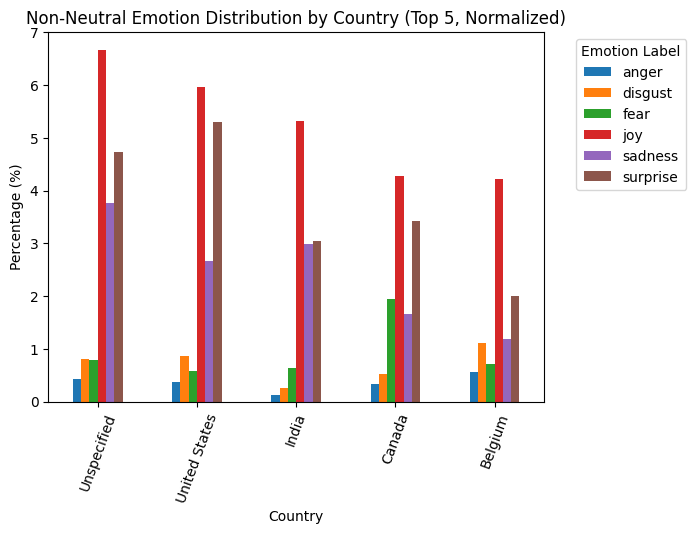

In [ ]:
# Plot the emotion distribution for the top 5 active countries (or unknown category)
df2_with_unspecified = df2.copy()
df2_with_unspecified['author_location'] = df2_with_unspecified['author_location'].fillna('unspecified')
top_countries = df1_with_unspecified['author_location'].value_counts().head(5).index

country_map = {country['iso']: country['name'] for country in gc.get_countries().values()}
country_map['unspecified'] = 'Unspecified'

country_emotion_counts = df2_with_unspecified[df2_with_unspecified['author_location'].isin(top_countries)].groupby(['author_location', 'emotion_label']).size().unstack(fill_value=0)
country_emotion = country_emotion_counts.div(country_emotion_counts.sum(axis=1), axis=0) * 100
country_emotion.index = country_emotion.index.map(lambda x: country_map.get(x, x))

emotion_cols = [emotion for emotion in country_emotion.columns if emotion != 'neutral']
country_emotion = country_emotion[emotion_cols]


country_emotion = country_emotion.sort_values(by='joy', ascending=False)

plt.figure(figsize=(20, 10))
country_emotion.plot(kind='bar')
plt.ylabel('Percentage (%)')
plt.xlabel('Country')
plt.title('Non-Neutral Emotion Distribution by Country (Top 5, Normalized)')
plt.legend(title='Emotion Label', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=70)